# Van der Pol
The Van der Pol equation is a second-order nonlinear ordinary differential equation used to model oscillatory systems with damping. It is expressed as:

\begin{equation}
    \frac{d^2x}{dt^2} = \mu(1 - x^2)\frac{dx}{dt} - x.
\end{equation}

where $x$ denotes the position coordinate. Its first derivative represents velocity, and its second derivative represents acceleration. The parameter $\mu$ controls the nonlinearity and damping strength. For small values of $\mu$, the system exhibits stable oscillations, while larger values of $\mu$ lead to more pronounced nonlinear behavior. The Van der Pol equation is often used to study nonlinear dynamics and serves as a classic example of self-sustained oscillations [[1]](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator).

In this tutorial, we use the Van der Pol equation as a straightforward example to demonstrate the CVODE solver. We choose a large value of $\mu$ to make the system stiff, and we match all input parameters and times to those in a similar example from [MATLAB](https://www.mathworks.com/help/matlab/math/differential-equations.html) for ease of comparison.

## Problem setup
Although the problem is a second-order ODE, most solvers are designed to be more efficient with first-order ODEs. Therefore, we will convert the problem to first-order derivatives by letting $y = [x, \dot{x}]$. Taking the derivative of $y$ gives $\dot{y} = [\dot{x}, \ddot{x}]$. This results in a system of two first-order ODEs, which can be written as:

\begin{align}
    \dot{y}_0 &= \dot{x} = y_1, \\
    \dot{y}_1 &= \ddot{x} = \mu(1 - x^2)\frac{dx}{dt} - x = \mu(1 - y_0^2)y_1 - y_0.
\end{align}

Notice how substitutions are used throughout the expressions to write the problem entirely in terms of $y$ rather than $x$. Once a problem is in a first-order form it can easily be translated into a Python function that the CVODE solver can interpret.

The CVODE solver is accessed by creating an instance of the `sundae.cvode.CVODE` class. The only required input is a right-hand-side function (`rhsfn`) that defines the $\dot{y}$ array of derivatives. Rather than a return value, `rhsfn` must have a signature like `f(t, y, yp)` where `yp` is a pre-allocated array that can be filled within the function. For more details, refer to the documentation. Below, the `rhsfn` function is set up to match the expressions above, with $\mu=1000$.

In [1]:
import numpy as np
import sksundae as sun
import matplotlib.pyplot as plt

def rhsfn(t, y, yp):
    yp[0] = y[1]
    yp[1] = 1000*(1 - y[0]**2)*y[1] - y[0]

## Solve and plot
Now that `rhsfn` is defined, it can be used to create an instance of `CVODE`. We will use all default options here, but note that many options for tolerance, constraints, and other parameters can be set during class initialization.

Once the solver is constructed, it can be run using one of two methods: `step` or `solve`. The `solve` method integrates over a defined time span while the `step` method performs one integration step at at time. First, we'll demonstrate how to use the `solve` method, which requires the integration time span and an initial condition `y0` (i.e., the values of $y$ at `tspan[0]`).

The solver detects how the solution should be recorded in time based on the length of `tspan`. When given exactly two values, as in the example below, the solver returns the solution at internally chosen time steps between the two values. When it is important to evaluate the solution at specific times, `tspan` should be an array with length greater than 2, specifying the times at which the solution should be recorded for output.


  message: Reached specified tstop.
  success: True
   status: 1
        t: [ 0.000e+00  2.686e-08 ...  2.979e+03  3.000e+03]
        y: [[ 2.000e+00  0.000e+00]
            [ 2.000e+00 -5.371e-08]
            ...
            [-1.534e+00  1.133e-03]
            [-1.510e+00  1.179e-03]]
 i_events: None
 t_events: None
 y_events: None
     nfev: 1921
     njev: 32



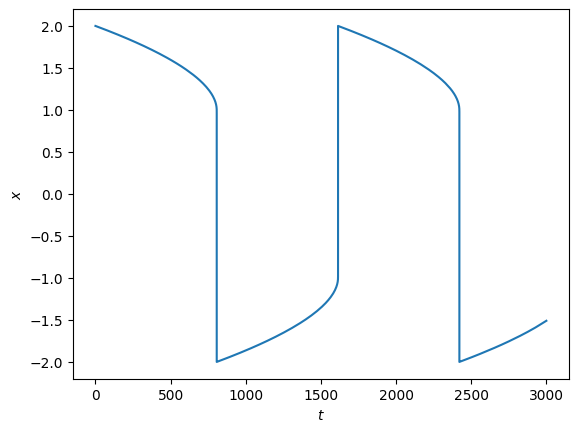

In [2]:
tspan = np.array([0, 3000])
y0 = np.array([2, 0])

solver = sun.cvode.CVODE(rhsfn)
soln = solver.solve(tspan, y0)
print(soln)

plt.plot(soln.t, soln.y[:,0])
plt.xlabel(r"$t$");
plt.ylabel(r"$x$");

## Step-wise solutions
Solving step-by-step instead of across a full time span can be beneficial in some cases, especially for debugging. Therefore, a `step` method is also available in `CVODE`. Before taking a step, the solver needs to know the initial conditions and time to determine the direction of integration for the following steps. Thus, before calling `step`, you should call `init_step`, as shown below. The initialization is handled automatically when using the `solve` method but must be done manually in a step-by-step approach.

Below, we run `init_step` and compare the solution `soln_0` to the initial values from the full solve, from above. Afterward, we take a step evaluated at `soln.t[10]` using the solution object from the full solve, allowing us to compare the step-by-step solution to a portion of the full solution. We only check that the solutions are within some tolerance (`1e-6`) because the solver's internal steps may differ from those in the full solution, meaning the values will be close but may not be exactly the same.

In [3]:
soln_0 = solver.init_step(0, y0)
print(soln_0)

assert soln_0.t == soln.t[0]
assert np.all(soln_0.y - soln.y[0] < 1e-6)

soln_1 = solver.step(soln.t[10])
print(soln_1)

assert soln_1.t == soln.t[10]
assert np.all(soln_1.y - soln.y[10] < 1e-6)


  message: Successful function return.
  success: True
   status: 0
        t: 0.0
        y: [ 2.000e+00  0.000e+00]
 i_events: None
 t_events: None
 y_events: None
     nfev: 0
     njev: 0


  message: Successful function return.
  success: True
   status: 0
        t: 0.0005614010396975667
        y: [ 2.000e+00 -5.451e-04]
 i_events: None
 t_events: None
 y_events: None
     nfev: 20
     njev: 1



The `step` method also has optional settings that you should explore and review in the full documentation.  Notably, there is a `method` keyword argument that controls how the step is taken. The `normal` method will  integrate all the way to the specified `t` value. Alternatively, you can use the `onestep` method which will allow the solver to take one internal time step toward `t`. This can result in the output value being somewhere between the previous time and the current `t` value, or may also result in the solver taking a step past the "requested" `t`. If you want to guarantee the solver does not step past a given time, use the `tstop` option. You can read more about `tstop` in the full documentation.

Although it might be tempting to use the `step` method to mix taking steps both forward and backward in time, relative to a previous step, the solver is designed to integrate in a single direction. Therefore, each time step should be chosen carefully (or `tstop` should be set for each step) to avoid stepping past a value that you cannot return to.

## Advanced features
The CVODE solver offers many advanced settings and controls. While we won't cover all of them in detail, we will discuss two important ones: (1) event functions and (2) Jacobian functions.

### Event functions
Event functions allow the solver to record solutions based on some criteria of interest, and if requested, can also terminate the solution when the criteria occurs. As a basic example, imagine throwing a ball straight up in the air and tracking its vertical position. You may want to record the time and location in which the ball reaches a maximum height, and also may want to force the solver the quit when the ball hits the ground so that you do not end up with unphysical solutions (i.e., the ball had negative height). To allow the solver to track events, you need to define a function with a signature like `f(t, y, events)`. Inside the function, the `events` array should be filled with expressions that define an event. An event is triggered if any `events[i] = 0` during the solve. The solver needs to know two things when using events: (1) the events function itself, passed using the `eventsfn` keyword argument, and (2) the number of events to track, passed using `num_events`. Below we set up two events that track when `y[0]` is equal to 1 and when `y[1] = yp[0] = 0` (i.e., when the oscillator changes direction).

After being defined, you may also decide to change the optional `terminal` and `direction` attributes for your events function. These attributes dictate what happens when an event occurs. Each attribute must be a list with the same number of values as `num_events`, allowing each event to have its own terminal and direction behavior. `terminal` values can be `True` or `False` to specify that the solver should or should not stop integrating when the specified event occurs, respectfully. You can also set an integer `terminal` value to tell the solver that it should only exit after the corresponding event has occurred some number of times. `direction` specifies when an event should be ignored based on the sign change of an `events[i]` expression. In the example below, the `terminal` and `direction` values are set to do the following:

* Tell the solver to stop only after `y[0] = 1` has occurred three times.
* Record the solution when `y[1] = 0`, but do not stop integration if this occurs.
* Regardless of which direction `y[0] = 1` happens (i.e., when `events[0]` has either positive or negative slope), record this event and include it toward the `terminal` count.
* The `y[1] = 0` event should only be recorded if `events[1]` has a positive slope when it is detected. Therefore, `y[1] = yp[0]` went from being negative to positive (a local minima). Although `y[1] = yp[0] = 0` may also represent a local maxima, these are ignored here. 


  message: Detected one or more events.
  success: True
   status: 2
        t: [ 0.000e+00  2.686e-08 ...  2.421e+03  2.421e+03]
        y: [[ 2.000e+00  0.000e+00]
            [ 2.000e+00 -5.371e-08]
            ...
            [ 1.001e+00 -9.669e-02]
            [ 1.000e+00 -1.021e-01]]
 i_events: [[-1  0]
            [ 0  1]
            [ 1  0]
            [-1  0]]
 t_events: [ 8.068e+02  8.069e+02  1.614e+03  2.421e+03]
 y_events: [[ 1.000e+00 -1.021e-01]
            [-2.000e+00  2.260e-14]
            [ 1.000e+00  1.334e+03]
            [ 1.000e+00 -1.021e-01]]
     nfev: 1478
     njev: 25



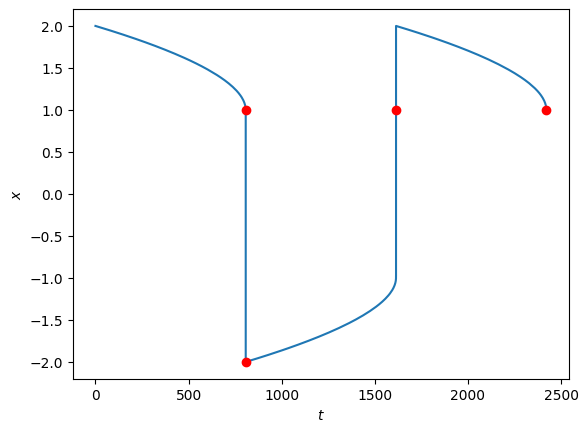

In [4]:
def eventsfn(t, y, events):
    events[0] = y[0] - 1
    events[1] = y[1]
    
eventsfn.terminal = [3, False]
eventsfn.direction = [0, 1]
    
solver = sun.cvode.CVODE(rhsfn, eventsfn=eventsfn, num_events=2)
soln = solver.solve(tspan, y0)
print(soln)

plt.plot(soln.t, soln.y[:,0], '-', soln.t_events, soln.y_events[:,0], 'or')
plt.xlabel(r"$t$");
plt.ylabel(r"$x$");

The solution output demonstrates that the events were tracked correctly. All specified events were tracked and recorded according to the specified settings. In addition to the `t_events` and `y_events` values in the solution object, which are self explanatory, the `i_events` field gives you information on which event triggered each record and which direction the event was detected going when it was recorded. For example, the first row means that the `events[0]` expression was detected with negative slope.

There are a couple more things you should be aware of if you decide to use events. First, if you don't specify `terminal` or `direction`, the default behavior is to make all events terminate integration on their first occurrence and to track both positive and negative slopes for each `events[i]`. Lastly, when an event is terminal, the results for that event occurrence are output to both the main arrays (`t` and `y`) and then "events" arrays (`t_events` and `y_events`) within the solution object. In contrast, if an event is not terminal, it is only recoded in the "events" arrays.

### Jacobian functions
In this simple and small problem, the solver is already fast and requires minimal computational effort. However, for larger problems, you can benefit from explicitly defining the Jacobian of your system. When the Jacobian is not provided, the solver numerically approximates it by perturbing the state variables $y$. For large systems of equations, this numerical approximation can be time-consuming, especially if performed frequently, which may significantly slow down the integrator. In such a case, you may benefit from defining the Jacobian function yourself. The Jacobian is defined as 

\begin{equation}
    J_{ij} = \frac{df_i}{dy_j},
\end{equation}

where $f_i$ are the right-hand-side expressions from `rhsfn` and $y_j$ are the variables in the $y$ array. Note that the Jacobian is a 2D array where each row corresponds to an $f$ expression and each column is associated with a specific $y$. The Jacobian function must have a signature like `J(t, y, yp, JJ)` where `JJ` is a pre-allocated 2D array that should be filled within the function. `yp` are the values of the `rhsfn` at the current time. The Jacobian function for the Van der Pol problem is given below and is passed to the solver using the `jacfn` keyword argument.


  message: Reached specified tstop.
  success: True
   status: 1
        t: [ 0.000e+00  2.686e-08 ...  2.977e+03  3.000e+03]
        y: [[ 2.000e+00  0.000e+00]
            [ 2.000e+00 -5.371e-08]
            ...
            [-1.537e+00  1.128e-03]
            [-1.510e+00  1.180e-03]]
 i_events: None
 t_events: None
 y_events: None
     nfev: 1963
     njev: 32



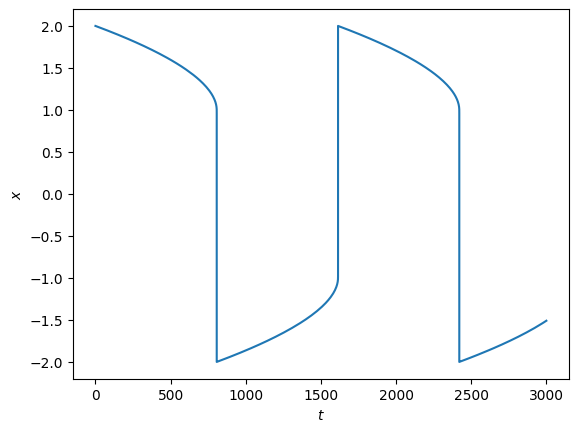

In [5]:
def jacfn(t, y, yp, JJ):
    JJ[0,0] = 0
    JJ[0,1] = 1
    JJ[1,0] = -2000*y[0]*y[1] - 1
    JJ[1,1] = 1000*(1 - y[0]**2)
    
solver = sun.cvode.CVODE(rhsfn, jacfn=jacfn)
soln = solver.solve(tspan, y0)
print(soln)

plt.plot(soln.t, soln.y[:,0])
plt.xlabel(r"$t$");
plt.ylabel(r"$x$");

You should consider providing the Jacobian for your problem when the number of Jacobian evaluations (`njev`) is large or when the problem size is substantial and the solver is slow to return results.

In some cases, you may also be able to speed up the solver without explicitly providing the Jacobian. If your problem has a banded Jacobian, you can switch to the banded solver using the option `linsolver='band'` when initializing your class. You will also need to specify the lower and upper bandwidths using the `lband` and `uband` options. This approach avoids the need to explicitly write out the Jacobian. The numerical algorithm for approximating banded Jacobians is significantly more efficient than the default `dense` method for problems having sparse Jacobians with narrow bandwidths. However, if the bandwidth is large, it may still be beneficial to explicitly provide `jacfn`. Both `dense` and `band` linear solvers support the `jacfn` option, but the `band` option will generally be faster if your bandwidth is less than the full matrix dimensions.